# Stanford CME 241 (Winter 2024) - Assignment 2

**Due: Jan 22 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Please solve questions 1 and 2, and choose one of questions 3 or 4.**
- Questions 1 and 2 of this homework focus on Markov Processes (MP and MRP) that were taught in class in the second week and are covered in Chapter 3 of the book.
- Questions 3 and 4 cover Markov Decision Processes that will be taught in the third week and are covered in Chapter 4 of the book.
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):*

https://github.com/HenriqueMonteiro35/RL-book/blob/master/assignment2.ipynb

### Arantxa Ramos del Valle - aramosv
### Boris Beltinoff - borisoff
### Henrique Bittencourt Netto Monteiro - hbnm

## Imports

In [1]:
from rl.distribution import Categorical, Constant
from rl.markov_process import FiniteMarkovProcess, FiniteMarkovRewardProcess
from collections import Counter
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

## Question 1
In the classic childhood game of Snakes and Ladders, all players start to the left of square 1 (call this position 0) and roll a 6-sided die to represent the number of squares they can move forward. The goal is to reach square 100 as quickly as possible. Landing on the bottom rung of a ladder allows for an automatic free-pass to climb, e.g. square 4 sends you directly to 14; whereas landing on a snake's head forces one to slide all the way to the tail, e.g. square 34 sends you to 6. Note, this game can be viewed as a Markov Process, where the outcome is only depedent on the current state and not the prior trajectory. In this question, we will ask you to both formally describe the Markov Process that describes this game, followed by coding up a version of the game to get familiar with the RL-book libraries.

![2_snakes_and_ladders.png](2_snakes_and_ladders.png)

### **Note: we are adopting the convention that both going up a ladder and down a snake are forced (mandatory) movements performed in a single, separate "turn"/action from the die movements. We are also adopting the convention that the game only terminates once the player lands at exactly tile 100 and will otherwise stay in the same place if they "overshoot."**

### Part a
Formalize the state space of the Snakes and Ladders game.

**ANSWER:** In this Markov Process, there are 100 squares and an initial position. Therefore, there are 101 different states. The state space goes from 0 (initial state) to 100 (winning square). There is one terminal state, being square 100. 

$$
\mathcal{S}=\{ 0, 1, 2, \ldots, 100\}
$$

$$
\mathcal{N}=\{ 0, 1, 2, \ldots, 99\}
$$
$$
\mathcal{T}=\{ 100\}
$$

To summarize:
- $s_0$: initial state, which represents the starting position.
- $s_{ 1-99}$: numbered squares on the board.
- $s_{100}$: terminal state, which is the winning square.


Following our convention that going up a ladder or down a snake counts as a single, separate action, it is possible to land in any square. That said, if the player lands at the top of a snake, they would be pushed all the way down to the tail in the next turn. Similarly, if the player lands on the bottom of a ladder, they would climb all the way up in the next turn.

### Part b
Write out the structure of the transition probabilities. Feel free to abbreviate all squares that do not have a snake or ladder.

**ANSWER:** The transition probability for a non-special (without snake heads and ladder bottoms) square $s_i$:
- The probability of transitioning to the square $s_{i+j}$, where $j$ is the die roll (from 1 to 6), is 1/6, i.e.: $\mathcal{P}(s_{i},s_{i+j}) = 1/6$.
- In the cases where $i+j$ exceeds 100, the player doesn't move. Therefore, the probability of staying in the state $s_i$ is the sum of the probabilities of all rolls that would result in moving beyond 100, i.e. $\mathcal{P}(s_{i},s_{i}) = (i-94)/6$ for all $95 < i < 100$ and $\mathcal{P}(s_{i},s_{i+j}) = 1/6$ as before for all $i + j \leq 100$.

For special squares:
- For squares that have a ladder bottom, the probability of transitioning up the ladder is 1. ( $\mathcal{P}(s_1, s_{38})=1$, $\mathcal{P}(s_4,s_{14})=1$, $\mathcal{P}(s_8,s_{30})=1$, $\mathcal{P}(s_{21},s_{42})=1$, $\mathcal{P}(s_{28},s_{76})=1$, $\mathcal{P}(s_{50},s_{67})=1$, $\mathcal{P}(s_{71},s_{92})=1$, $\mathcal{P}(s_{80},s_{99})=1$ )
- For squares that have a snake head, the probability of transitioning down the snake is 1. ( $\mathcal{P}(s_{32}, s_{10})=1$, $\mathcal{P}(s_{36},s_6)=1$, $\mathcal{P}(s_{48},s_{26})=1$, $\mathcal{P}(s_{62},s_{18})=1$, $\mathcal{P}(s_{88},s_{24})=1$, $\mathcal{P}(s_{95},s_{56})=1$, $\mathcal{P}(s_{97},s_{78})=1$ )


### Part c
Code up a `transition_map: Transition[S]` data structure to represent the transition probabilities of the Snakes and Ladders Markov Process so you can model the game as an instance of `FiniteMarkovProcess`. Use the `traces` method to create sampling traces.

In [2]:
# Define the states
@dataclass(frozen=True)
class StateSL():
    state: int

ladders_ex = {1: 38, 4: 14, 8: 30, 21: 42, 28: 76, 50: 67, 71: 92, 80: 99}
snakes_ex = {32: 10, 36: 6, 48: 26, 62: 18, 88: 24, 95: 56, 97: 78}
special_ex = {**ladders_ex, **snakes_ex}

transition_map = {
    **{tile: Constant(next_state) for (tile, next_state) in special_ex.items()},
    **{tile: Categorical({tile+j: 1/6 for j in range(1, 6+1)}) for tile in range(0, 94+1) if tile not in special_ex},
    **{i: Categorical({**{j: 1/6 for j in range(i+1, 100+1)}, **{i: (i-94)/6}}) for i in range(95, 100) if i not in special_ex},
}

transition_map

{1: Constant(value=38),
 4: Constant(value=14),
 8: Constant(value=30),
 21: Constant(value=42),
 28: Constant(value=76),
 50: Constant(value=67),
 71: Constant(value=92),
 80: Constant(value=99),
 32: Constant(value=10),
 36: Constant(value=6),
 48: Constant(value=26),
 62: Constant(value=18),
 88: Constant(value=24),
 95: Constant(value=56),
 97: Constant(value=78),
 0: {1: 0.16666666666666669, 2: 0.16666666666666669, 3: 0.16666666666666669, 4: 0.16666666666666669, 5: 0.16666666666666669, 6: 0.16666666666666669},
 2: {3: 0.16666666666666669, 4: 0.16666666666666669, 5: 0.16666666666666669, 6: 0.16666666666666669, 7: 0.16666666666666669, 8: 0.16666666666666669},
 3: {4: 0.16666666666666669, 5: 0.16666666666666669, 6: 0.16666666666666669, 7: 0.16666666666666669, 8: 0.16666666666666669, 9: 0.16666666666666669},
 5: {6: 0.16666666666666669, 7: 0.16666666666666669, 8: 0.16666666666666669, 9: 0.16666666666666669, 10: 0.16666666666666669, 11: 0.16666666666666669},
 6: {7: 0.16666666666666669

In [3]:
fmp = FiniteMarkovProcess[StateSL](transition_map)

def get_traces(num_traces):
    traces = []
    for _ in range(num_traces):
        state = StateSL(0)
        trace = [state]
        while state.state != 100:
            state = fmp.transition(state).sample()
            trace.append(state)
        traces.append(trace)
    return traces

get_traces(5)

[[StateSL(state=0),
  NonTerminal(state=2),
  NonTerminal(state=6),
  NonTerminal(state=11),
  NonTerminal(state=17),
  NonTerminal(state=22),
  NonTerminal(state=24),
  NonTerminal(state=28),
  NonTerminal(state=76),
  NonTerminal(state=80),
  NonTerminal(state=99),
  NonTerminal(state=99),
  Terminal(state=100)],
 [StateSL(state=0),
  NonTerminal(state=4),
  NonTerminal(state=14),
  NonTerminal(state=20),
  NonTerminal(state=26),
  NonTerminal(state=30),
  NonTerminal(state=35),
  NonTerminal(state=36),
  NonTerminal(state=6),
  NonTerminal(state=8),
  NonTerminal(state=30),
  NonTerminal(state=35),
  NonTerminal(state=37),
  NonTerminal(state=41),
  NonTerminal(state=47),
  NonTerminal(state=53),
  NonTerminal(state=54),
  NonTerminal(state=57),
  NonTerminal(state=61),
  NonTerminal(state=67),
  NonTerminal(state=71),
  NonTerminal(state=92),
  NonTerminal(state=96),
  NonTerminal(state=96),
  NonTerminal(state=96),
  NonTerminal(state=98),
  Terminal(state=100)],
 [StateSL(state=0

### Part d
Plot the sample traces and a graph of the distribution of time steps to finish the game.

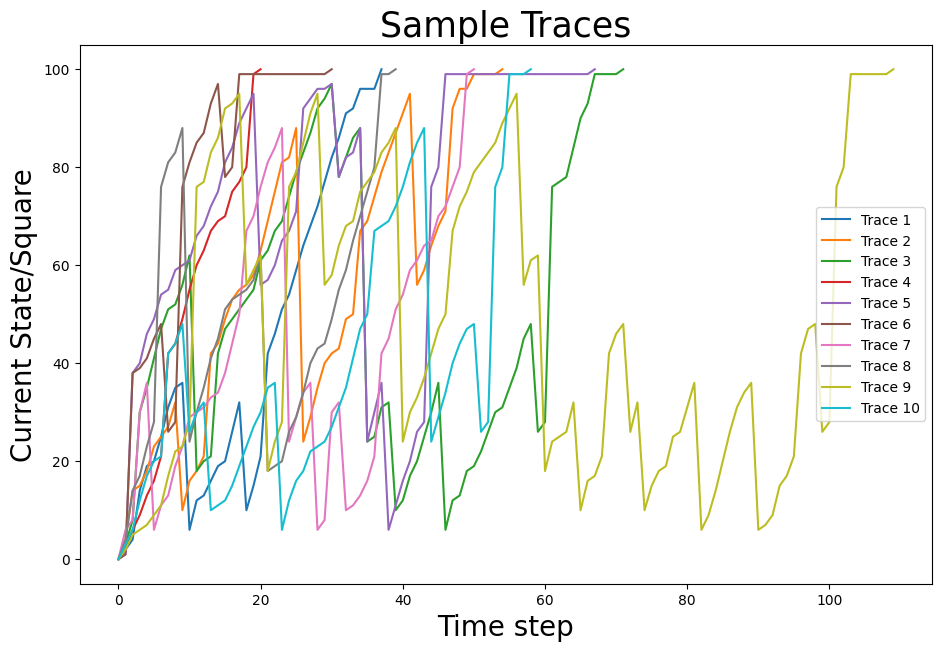

In [4]:
traces = get_traces(10)
plt.figure(figsize=(11, 7))
for i, trace in enumerate(traces):
    plt.plot([state.state for state in trace], label=f'Trace {i+1}')

plt.legend()
plt.xlabel('Time step',fontsize=20)
plt.ylabel('Current State/Square',fontsize=20)
plt.title("Sample Traces",fontsize=25)
plt.show()

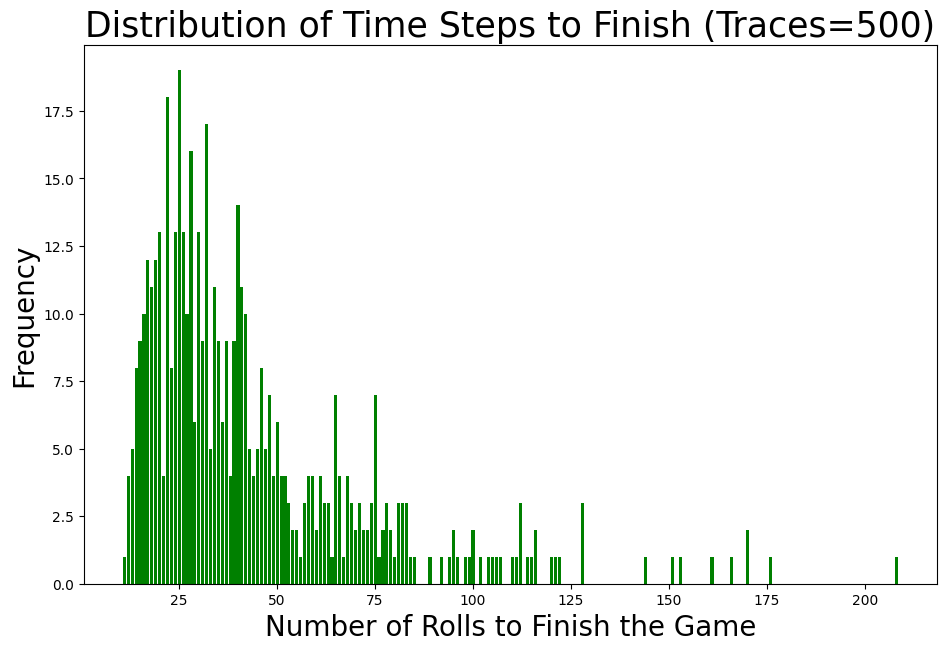

In [5]:
num_traces = 500
traces = get_traces(num_traces)
time_steps_finish = [len(trace) for trace in traces]
counter = Counter(time_steps_finish)

keys = list(counter.keys())
values = list(counter.values())

# Plot the frequency
plt.figure(figsize=(11, 7))
plt.bar(keys, values,color='green')
plt.xlabel('Number of Rolls to Finish the Game',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.title(f"Distribution of Time Steps to Finish (Traces={num_traces:d})",fontsize=25)
plt.show()

### Part e
For the Snakes and Ladders game, calculate the expected number of rolls to finish the game. Hint: in order to calculate this, extend the Snakes and Ladders `FiniteMarkovProcess` to an appropriate `FiniteMarkovRewardProcess` instance. What should be the Rewards model in this MRP so you can use one of the methods in the `FiniteMarkovRewardProcess` class to determine the expected number of dice rolls to finish the game?

**ANSWER:** if we use gamma = 1.0 (no discounting) and apply a reward of 1.0 at every transition, then the value function at state 0 should equal the expected number of turns to finish the game. Since we count as a turn going up the ladder or down the snake, **our count may be slightly higher than that of students who used a different convention**.

Expected number of turns (including up ladder and down snake as a separate turn): 44.70984562422662


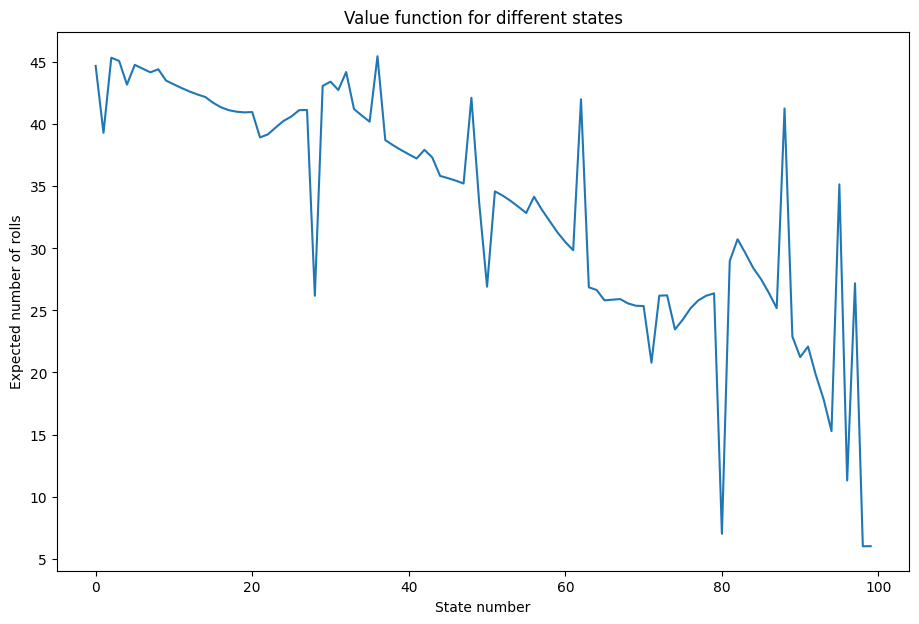

In [6]:
transition_map_reward = {
    **{tile: Constant(next_state).map(lambda x: (x, 1.0)) for (tile, next_state) in special_ex.items()},
    **{tile: Categorical({tile+j: 1/6 for j in range(1, 6+1)}).map(lambda x: (x, 1.0)) for tile in range(0, 94+1) if tile not in special_ex},
    **{i: Categorical({**{j: 1/6 for j in range(i+1, 100+1)}, **{i: (i-94)/6}}).map(lambda x: (x, 1.0)) for i in range(95, 100) if i not in special_ex},
}

fmrp = FiniteMarkovRewardProcess(transition_map_reward)
value_function = fmrp.get_value_function_vec(gamma=1.0)
sorted_mask = np.argsort([state.state for state in fmrp.non_terminal_states])

print(f"Expected number of turns (including up ladder and down snake as a separate turn): {value_function[sorted_mask][0]}")

plt.figure(figsize=(11, 7))
plt.plot(np.array([state.state for state in fmrp.non_terminal_states])[sorted_mask], value_function[sorted_mask])
plt.title("Value function for different states")
plt.xlabel("State number")
plt.ylabel("Expected number of rolls")
plt.show()

## Question 2
Consider the problem of a frog jumping across a river with $n=9$ lilypads. The frog at every time step will randomly jump to a position in front of it (e.g. at the starting step, the frog will jump with $\frac{1}{10}$ probability to each of the lilypads or $\frac{1}{10}$ to the other side of the river). A diagram of the frog jumping problem is below.

![2_jumping.png](2_jumping.png)

# *NOTE: this was the question meant to be done by Boris.*

### Part a
Formalize the states of the jumping frog problem as well as the structure of the transition probabilites.

### Part b
Compute the expected number of steps that it would take for the frog to reach the other side.

### Part c
Provide a closed form solution for the expected number of steps / jumps to cross the river for arbitrary $n$. A formal proof is not required.

## Question 3
Consider an MDP with an infinite set of states $\mathcal{S} = \{1,2,3,\ldots \}$. The start state is $s=1$. Each state $s$ allows a continuous set of actions $a \in [0,1]$. The transition probabilities are given by: $$\mathbb{P}[s+1 \mid s, a] = a, \mathbb{P}[s \mid s, a] = 1 - a \text{ for all } s \in \mathcal{S} \text{ for all } a \in [0,1]$$
For all states $s \in \mathcal{S}$ and actions $a \in [0,1]$, transitioning from $s$ to $s+1$ results in a reward of $1-a$ and transitioning from $s$ to $s$ results in a reward of $1+a$. The discount factor $\gamma=0.5$.

### Part a
Using the MDP Bellman Optimality Equation, calculate the Optimal Value Function $V^*(s)$ for all $s \in \mathcal{S}$

**ANSWER:** Following the notation from the class and book, we start with the MDP Bellman Optimality Equation for all $s \in \mathcal{N}$,

$$
V^*(s) = \max_{a \in \mathcal{A}} \{  \mathcal{R}(s, a) + \gamma \sum_{s' \in \mathcal{N}} \mathcal{P}(s, a, s') V^*(s') \}
$$

Note that the action space is the same for all states and that the probability of rewards depend only on the action; the current state does not matter. This allows an important simplification as the optimal value function $V^*(s)$ should be the same for all $s \in \mathcal{S}$. Therefore,

$$
V^*(s) = \max_{a \in \mathcal{A}} \{  \mathcal{R}(s, a) + \gamma V^*(s) \sum_{s' \in \mathcal{N}} \mathcal{P}(s, a, s') \}
$$

We expand the rewards using the probabilities given,

$$
V^*(s) = \max_{a \in \mathcal{A}} \{ a (1 - a) + (1 - a) (1 + a) + \gamma V^*(s) \}
$$

$$
(1 - \gamma) V^*(s) = \max_{a \in \mathcal{A}} \{ - 2 a^2 + a + 1 \}
$$

The RHS is a quadratic function of $a$ with negative second derivative, so the maximization problem is convex with unique global maximizer. We differentiate and equate to zero,

$$
-4 a + 1 = 0 \implies a = \frac{1}{4}
$$

$$
\max_{a \in \mathcal{A}} \{ - 2 a^2 + a + 1 \} = - \frac{1}{8} + \frac{1}{4} + 1 = \frac{9}{8}
$$

Finally,

$$
V^*(s) = \frac{9}{8(1 - \gamma)} \implies V^*(s) = \frac{9}{4}
$$

### Part b
Calculate an Optimal Deterministic Policy $\pi^*(s)$ for all $s \in \mathcal{S}$

**ANSWER:** as seen above, an optimal deterministic policy $\pi^*(s)$ for all $s \in \mathcal{S}$ is to choose $a = \frac{1}{4}$ with probability 1 at every state.

More formally, we can easily show that such policy maximizes the value function, i.e. $V^*(s) = V^{\pi^*}(s)$ for all $s \in \mathcal{S}$ such that it must be optimal,

\begin{align}
V^{\pi^*}(s) &= \sum_{k = 0}^{\infty} \gamma^k \mathcal{R}(s, a^{\pi^*}) \\
&= \sum_{k = 0}^{\infty} \gamma^k \left[ \frac{1}{4} \left( 1 - \frac{1}{4} \right) + \left( 1 - \frac{1}{4} \right) \left( 1 + \frac{1}{4} \right) \right] \\
&= \sum_{k = 0}^{\infty} \gamma^k \left[ \frac{3}{16} + \frac{15}{16} \right] \\
&= \frac{9}{8} \frac{1}{1 - \gamma} \\
&= \frac{9}{4} \\
&= V^*(s)
\end{align}

## Question 4
Consider again the problem of a frog jumping across a river with $n-1$ lilypads, labeled $1, \dots, n-1$, with the two riverbanks labeled positions $0$ and $n$. At each time step, the frog who is at lilypad $i$ has two options:
- (Strategy A) The frog moves to lilypad $i-1$  with probability $\frac{i}{n}$ and moves to lilypad $i+1$ otherwise.
- (Strategy B) The frog moves to arbitrary position from $0,\dots,n$ with equal probability.

The frog now starts on a random lilypad. A snake lives on one end of the river (say the snake lives at 0) and will eat the frog if it lands on this side of the river. The frog can escape by landing the other side of the river (i.e. position $n$). What should the frog's strategy be when on each of the lilypads $1, 2, \ldots, n-1$, in order to maximize the probability of escaping the pond (reaching $n$ before reaching $0$)? Although there are more than one ways of solving this problem, we would like to solve it by modeling it as an MDP and identifying the Optimal Policy.

Note: Sorry for all the frog jumping questions. These games are an easy way to understand Markov Processes, without having to build out too much detail of a financial simulation. Questions will be more related to finance over time.

### Part a
Express with clear mathematical notation the state space, the action space, transition function, and rewards function of an MDP so that the frog-escape problem would be solved by arriving at the Optimal Value Function (and hence, the Optimal Policy) of the MDP.

### Part b
Write code to model this MDP as an instance of the `FiniteMarkovDecisionProcess` class. We have learnt that there exists an optimal deterministic policy, and there are $2^{n-1}$ possible deterministic policies for this problem. Write code to create each of these $2^{n-1}$ deterministic policies (as instances of `FinitePolicy` class), create a policy-implied Finite MRP for each of these deterministic policies (using the `apply_finite_policy` method of `FiniteMarkovDecisionProcess` class), and evaluate the Value Function for each of those implied Finite MRPs (using the `get_value_function_vec` method of `FiniteMarkovRewardProcess` class). This should gives you the Optimal Value Function and the Optimal Deterministic Policy.

### Part c
Plot a graph of the Optimal Escape-Probability and of the associated strategies, as a function of the states of this MDP, for $n=3, n=6$ and $n=9$. By looking at the results on this graph, what pattern do you observe for the optimal policy as you vary $n$ from 3 to 9?

![2_frog.png](2_frog.png)